(RolloutWorker pid=81439) 2024-11-23 20:37:54,214	WARNING multi_agent_env.py:180 -- observation_space_contains() of <MAEnvironment instance> has not been implemented. You can either implement it yourself or bring the observation space into the preferred format of a mapping from agent ids to their individual observation spaces. 
(RolloutWorker pid=81439) 2024-11-23 20:37:54,214	WARNING multi_agent_env.py:180 -- observation_space_contains() of <MAEnvironment instance> has not been implemented. You can either implement it yourself or bring the observation space into the preferred format of a mapping from agent ids to their individual observation spaces. 
(RolloutWorker pid=81439) 2024-11-23 20:37:54,214	WARNING multi_agent_env.py:180 -- observation_space_contains() of <MAEnvironment instance> has not been implemented. You can either implement it yourself or bring the observation space into the preferred format of a mapping from agent ids to their individual observation spaces. 
(RolloutWo

Total trigger count for all agents: 470


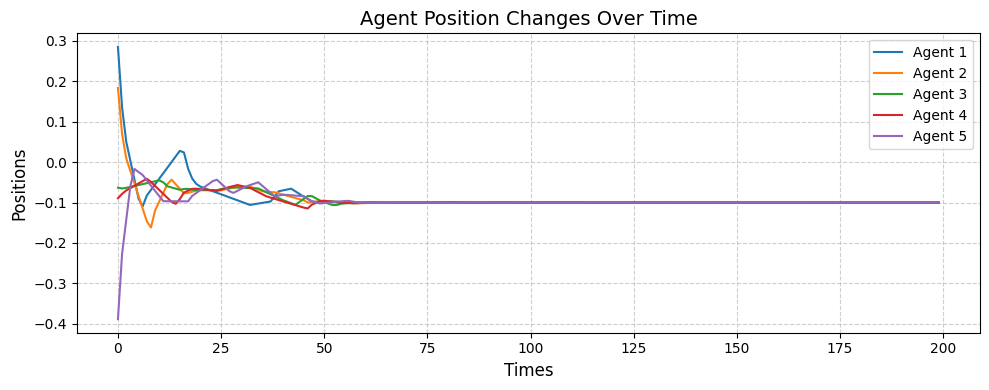

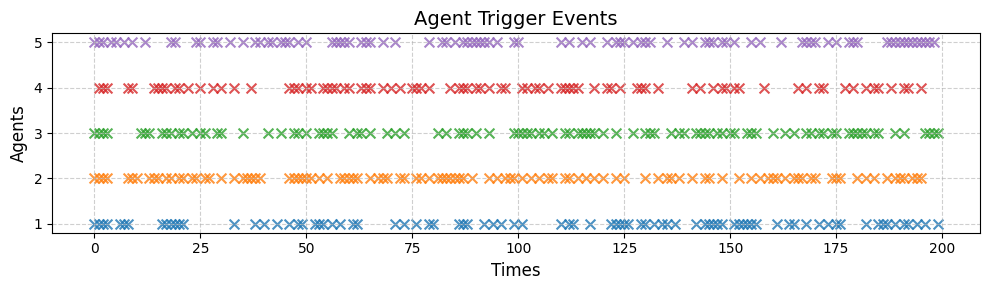

In [79]:
import numpy as np
from gym import spaces
from ray.rllib.env.multi_agent_env import MultiAgentEnv
from ray.rllib.algorithms.ppo import PPO
from ray.tune.registry import register_env
import matplotlib.pyplot as plt
import pickle
from ray.rllib.algorithms.ppo import PPO
from ray.rllib.policy.policy import Policy
# from env.MAenv import MAEnvironment


# 自定义环境定义
# 定义环境类
class MAEnvironment(MultiAgentEnv):
    def __init__(self, num_agents=5, num_iterations=200, dt=0.1):
        super().__init__()  # 调用父类初始化
        self.num_agents = num_agents
        self.agents = ["agent_" + str(i) for i in range(num_agents)]
        self.agent_name_mapping = dict(zip(self.agents, list(range(num_agents))))
        self._agent_ids = set(self.agents)  # 添加 _agent_ids 属性

        # 初始化其他属性
        self.num_iterations = num_iterations
        self.dt = dt
        self.current_iteration = 0

        initial_positions = [0.55, 0.4, -0.05, -0.1, -0.7]
        self.agent_objs = [self.Agent(pos, i) for i, pos in enumerate(initial_positions)]
        self.init_neighbors()

        self.epsilon = 0.005
        self.time_to_reach_epsilon = None
        self.epsilon_violated = True
        self.all_within_epsilon = False
        self.total_trigger_count = 0
        self.time_to_reach_epsilon_changes = 0
        self.max_obs_size = self.compute_max_obs_size()
    
    def compute_max_obs_size(self):
        max_neighbors = max(len(agent.neighbors) for agent in self.agent_objs)
        return 1 + max_neighbors
    
    def init_neighbors(self):
        self.agent_objs[0].add_neighbor(self.agent_objs[1])
        self.agent_objs[0].add_neighbor(self.agent_objs[2])
        self.agent_objs[0].add_neighbor(self.agent_objs[3])
        self.agent_objs[0].add_neighbor(self.agent_objs[4])
        self.agent_objs[1].add_neighbor(self.agent_objs[2])
        self.agent_objs[1].add_neighbor(self.agent_objs[3])
        self.agent_objs[1].add_neighbor(self.agent_objs[4])
        self.agent_objs[2].add_neighbor(self.agent_objs[3])
        self.agent_objs[2].add_neighbor(self.agent_objs[4])
        self.agent_objs[3].add_neighbor(self.agent_objs[4])

    def reset(self, *, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        
        initial_positions = [0.55, 0.4, -0.05, -0.1, -0.7]
        self.agent_objs = [self.Agent(pos, i) for i, pos in enumerate(initial_positions)]
        self.init_neighbors()
        self.current_iteration = 0
        self.epsilon_violated = True
        self.all_within_epsilon = False
        self.total_trigger_count = 0
        self.time_to_reach_epsilon_changes = 0
        self.time_to_reach_epsilon = None
        
        observations = {agent: self.get_observation(agent) for agent in self.agents}
        infos = {agent: {} for agent in self.agents}  # 返回额外的 per-agent 信息字典
        return observations, infos

    # 统一的观测空间
    # def get_observation(self, agent):
    #     agent_index = self.agent_name_mapping[agent]
    #     agent_obj = self.agent_objs[agent_index]
    #     neighbors_positions = [neighbor.position for neighbor in agent_obj.neighbors]
    #     obs = np.array([agent_obj.position] + neighbors_positions, dtype=np.float32)
        
    #     # 填充观测到最大观测大小
    #     if len(obs) < self.max_obs_size:
    #         padding = np.zeros(self.max_obs_size - len(obs))
    #         obs = np.concatenate([obs, padding])
        
    #     # 不进行裁剪
    #     return obs

    # 不同的观测空间
    def get_observation(self, agent):
        agent_index = self.agent_name_mapping[agent]
        agent_obj = self.agent_objs[agent_index]
        neighbors_positions = [neighbor.position for neighbor in agent_obj.neighbors]
        obs = np.array([agent_obj.position] + neighbors_positions, dtype=np.float32)
        return obs

    def compute_average_position_difference(self):
        total_difference = 0
        count = 0
        for i, agent_i in enumerate(self.agent_objs):
            for j, agent_j in enumerate(self.agent_objs):
                if i < j:
                    total_difference += abs(agent_i.position - agent_j.position)
                    count += 1
        if count > 0:
            return total_difference / count
        else:
            return 0
    
    def step(self, action_dict):
        triggers = np.array([action_dict.get(agent, 0) for agent in self.agents])  # 确保访问安全
        trigger_count = np.sum(triggers)
        self.total_trigger_count += trigger_count

        for i, agent in enumerate(self.agent_objs):
            agent.update_position(self.current_iteration, self.dt, triggers[i])

        self.all_within_epsilon = all(all(abs(agent.position - neighbor.position) < self.epsilon for neighbor in agent.neighbors) for agent in self.agent_objs)

        if self.all_within_epsilon:
            if self.epsilon_violated:
                self.time_to_reach_epsilon = self.current_iteration
                self.epsilon_violated = False
                self.time_to_reach_epsilon_changes += 1
        else:
            self.epsilon_violated = True
            self.time_to_reach_epsilon = None
        
        self.current_iteration += 1
        terminated = self.current_iteration >= self.num_iterations

        rewards = {}
        if not terminated:
            average_position_difference = self.compute_average_position_difference()
            for agent in self.agents:
                if self.all_within_epsilon:
                    rewards[agent] = 10 if action_dict.get(agent, 0) == 0 else 0  # 动作为0奖励，1惩罚
                else:
                    rewards[agent] = - 10 * np.abs(average_position_difference)
        else:
            if self.time_to_reach_epsilon is not None:
                global_reward = 5000 - self.time_to_reach_epsilon - self.total_trigger_count
            else:
                global_reward = -5000
            for agent in self.agents:
                rewards[agent] = global_reward

        observations = {agent: self.get_observation(agent) for agent in self.agents}
        terminateds = {agent: terminated for agent in self.agents}
        terminateds["__all__"] = terminated
        truncateds = {agent: False for agent in self.agents}  # 无需提前结束
        truncateds["__all__"] = False
        infos = {agent: {} for agent in self.agents}

        return observations, rewards, terminateds, truncateds, infos
    
    def render(self, mode='human'):
        positions = [agent.position for agent in self.agent_objs]
        print(f"Positions: {positions}")
    
    # 统一大小的观测空间
    # def observation_space(self, agent):
    #     return spaces.Box(low=-np.inf, high=np.inf, shape=(self.max_obs_size,), dtype=np.float32)
    
    def observation_space(self, agent):
        num_neighbors = len(self.agent_objs[self.agent_name_mapping[agent]].neighbors)
        obs_size = 1 + num_neighbors  # 自身位置 + 邻居数量
        return spaces.Box(low=-np.inf, high=np.inf, shape=(obs_size,), dtype=np.float32)
    
    def action_space(self, agent):
        return spaces.Discrete(2)

    class Agent:
        def __init__(self, initial_position, index):
            self.position = initial_position
            self.index = index
            self.neighbors = []
            self.last_broadcast_position = self.position
            self.trigger_points = []
            self.u_i = 0

        def add_neighbor(self, neighbor):
            if neighbor not in self.neighbors:
                self.neighbors.append(neighbor)
                neighbor.neighbors.append(self)

        def update_position(self, t, dt, trigger):
            if trigger == 1 or t == 0:
                self.u_i = -sum((self.last_broadcast_position - neighbor.last_broadcast_position) for neighbor in self.neighbors)
                self.position += self.u_i * dt
                self.last_broadcast_position = self.position
                self.trigger_points.append((t, self.position))
            else:
                self.position += self.u_i * dt


# 注册环境
register_env("custom_ma_env", lambda config: MAEnvironment(num_agents=config.get("num_agents", 5)))

# 配置
config = {
    "env": "custom_ma_env",  # 注册的环境名称
    "env_config": {"num_agents": 5},
    "framework": "torch",
    "multiagent": {
        "policies": {
            "shared_policy": (None, MAEnvironment(5).observation_space("agent_0"), MAEnvironment(5).action_space("agent_0"), {}),
        },
        "policy_mapping_fn": lambda agent_id, **kwargs: "shared_policy",
    },
    "num_workers": 0,
    "num_envs_per_worker": 1,
}

# # 加载模型（手动）
# checkpoint_path = "/Users/cyj/ray_results/PPO_2024-11-23_16-13-46/PPO_env_dc60a_00000_0_2024-11-23_16-13-46/checkpoint_000000/policies/shared_policy/policy_state.pkl"
# ppo_trainer = PPO(config=config)
# with open(checkpoint_path, "rb") as f:
#     policy_state = pickle.load(f)
# ppo_trainer.get_policy("shared_policy").set_state(policy_state)

# # 仿真
# num_steps = 200
# env = MAEnvironment(num_agents=5)
# agent_positions = {agent: [] for agent in env.agents}
# agent_triggers = {agent: [] for agent in env.agents}
# observations, _ = env.reset()

# for step in range(num_steps):
#     action_dict = {}
#     for agent in env.agents:
#         action_dict[agent] = ppo_trainer.get_policy("shared_policy").compute_single_action(observations[agent])[0]
#     observations, _, terminateds, _, _ = env.step(action_dict)
#     for i, agent_obj in enumerate(env.agent_objs):
#         agent_positions[env.agents[i]].append(agent_obj.position)
#         agent_triggers[env.agents[i]].append(action_dict[env.agents[i]])
#     if terminateds["__all__"]:
#         break


# 注册环境
register_env("env", lambda config: MAEnvironment(num_agents=config.get("num_agents", 5)))

# 检查点路径
checkpoint_path = "/Users/cyj/ray_results/PPO_2024-11-23_20-29-59/PPO_env_a7d11_00000_0_2024-11-23_20-29-59/checkpoint_000007"

# 恢复完整的 PPO 训练器
restored_trainer = PPO.from_checkpoint(checkpoint_path)

# 仿真
num_steps = 200
env = MAEnvironment(num_agents=5)
agent_positions = {agent: [] for agent in env.agents}
agent_triggers = {agent: [] for agent in env.agents}
observations, _ = env.reset()

for step in range(num_steps):
    action_dict = {}
    for agent in env.agents:
        action_dict[agent] = restored_trainer.get_policy("shared_policy").compute_single_action(observations[agent])[0]
    observations, _, terminateds, _, _ = env.step(action_dict)
    for i, agent_obj in enumerate(env.agent_objs):
        agent_positions[env.agents[i]].append(agent_obj.position)
        agent_triggers[env.agents[i]].append(action_dict[env.agents[i]])
    if terminateds["__all__"]:
        break

total_trigger_count = sum(sum(triggers) for triggers in agent_triggers.values())
print(f"Total trigger count for all agents: {total_trigger_count}")

# 绘制智能体位置的变化
plt.figure(figsize=(10, 4))
for i, (agent, positions) in enumerate(agent_positions.items()):
    plt.plot(positions, label=f"Agent {i + 1}")
plt.xlabel("Times", fontsize=12)
plt.ylabel("Positions", fontsize=12)
plt.title("Agent Position Changes Over Time", fontsize=14)
plt.legend(loc="best", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 绘制触发事件
plt.figure(figsize=(10, 3))
for i, (agent, triggers) in enumerate(agent_triggers.items()):
    trigger_times = [t for t, val in enumerate(triggers) if val == 1]  # 获取触发动作为 1 的时间步
    plt.scatter(trigger_times, [i + 1] * len(trigger_times), marker='x', label=f"Agent {i + 1}", s=50, alpha=0.8)

plt.xlabel("Times", fontsize=12)
plt.ylabel("Agents", fontsize=12)
plt.title("Agent Trigger Events", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(range(1, len(agent_triggers) + 1), fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()